   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 6.0 MB/s eta 0:00:00
================================= RESULTADOS =================================
Matriz de confusión (filas=verdad, columnas=predicción):
[[194 100]
 [ 42 264]]

Desglose (TN, FP, FN, TP) = (194, 100, 42, 264)

Accuracy (exactitud):
  Valor = 0.7633
  ¿Cómo se calcula? (TP + TN) / (TP + TN + FP + FN)
  ¿Qué significa? Proporción total de aciertos; puede ser engañosa con clases desbalanceadas.

Precision (precisión positiva):
  Valor = 0.7253
  ¿Cómo se calcula? TP / (TP + FP)
  ¿Qué significa? De todo lo que predije como POSITIVO, ¿qué fracción era realmente positivo?

Recall (sensibilidad, TPR):
  Valor = 0.8627
  ¿Cómo se calcula? TP / (TP + FN)
  ¿Qué significa? De todos los POSITIVOS reales, ¿qué fracción detecté? Mide falsos negativos.

Specificity (especificidad, TNR):
  Valor = 0.6599
  ¿Cómo se calcula? TN / (TN + FP)
  ¿Qué significa? De todos los NEGATIVOS reales, ¿qué fracción reconocí bien? Mide f

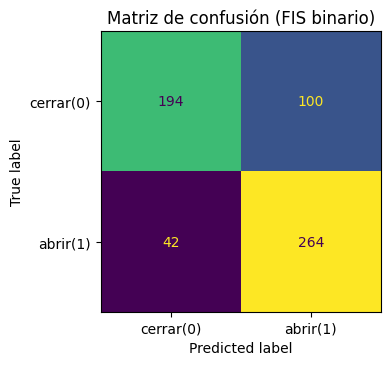

================================= EJEMPLO ==================================
Entrada de ejemplo: error_nivel=15, tasa_cambio=6
Salida crisp (0..100): 78.53
Probabilidad difusa de 'abrir'(1): 1.000
Decisión binaria con umbral 0.5 -> clase: abrir(1)
Interpretación: el error positivo sugiere que falta nivel; si además la tasa sube, el sistema favorece 'abrir'.


In [1]:
# --- Instalación de dependencias (solo necesario en Colab) ---
# Nota: el flag -q suprime mensajes extensos de instalación
!pip -q install scikit-fuzzy scikit-learn matplotlib numpy

# --- Imports de librerías necesarias ---
import numpy as np                               # Cálculo numérico
import matplotlib.pyplot as plt                  # Gráficas
from sklearn.metrics import (                    # Métricas de clasificación
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report
)
from sklearn.model_selection import train_test_split  # Partición de datos

import skfuzzy as fuzz                           # Núcleo de lógica difusa
from skfuzzy import control as ctrl              # Sistema de control difuso (Mamdani)

# --- Fijamos semilla para reproducibilidad ---
np.random.seed(42)

# ============================================================================================
# 1) Definición del FIS (Mamdani)
#    Entradas: error_nivel ([-50,50]), tasa_cambio ([-20,20])
#    Salida  : accion_valvula (0..100) -> clase binaria: cerrar(0) vs abrir(1)
# ============================================================================================

# Definimos universos de discurso (rangos discretizados)
error = ctrl.Antecedent(np.linspace(-50, 50, 501), 'error_nivel')   # Error = setpoint - nivel
tasa  = ctrl.Antecedent(np.linspace(-20, 20, 401), 'tasa_cambio')   # Derivada del nivel
accion = ctrl.Consequent(np.linspace(0, 100, 101), 'accion_valvula')# Salida (0..100)

# Funciones de membresía para 'error' (triangulares)
error['neg']  = fuzz.trimf(error.universe, [-50, -50,   0])         # Error negativo (nivel por encima)
error['cero'] = fuzz.trimf(error.universe, [ -10,   0,  10])        # Error cercano a cero
error['pos']  = fuzz.trimf(error.universe, [   0,  50,  50])        # Error positivo (nivel por debajo)

# Funciones de membresía para 'tasa' (triangulares)
tasa['bajando']  = fuzz.trimf(tasa.universe, [-20, -20,   0])       # Nivel disminuye
tasa['estable']  = fuzz.trimf(tasa.universe, [  -5,   0,   5])      # Nivel estable
tasa['subiendo'] = fuzz.trimf(tasa.universe, [   0,  20,  20])      # Nivel aumenta

# Funciones de membresía para la salida 'accion' (dos clases lingüísticas)
accion['cerrar'] = fuzz.trimf(accion.universe, [ 0,  0, 50])        # Cerrar válvula (bajos)
accion['abrir']  = fuzz.trimf(accion.universe, [50, 100,100])       # Abrir válvula (altos)

# Reglas difusas (IF-THEN) de sentido físico intuitivo
rule1 = ctrl.Rule(error['pos'] | tasa['subiendo'], accion['abrir']) # Si error>0 o sube -> abrir
rule2 = ctrl.Rule(error['neg'] & tasa['bajando'], accion['cerrar']) # Si error<0 y baja -> cerrar
rule3 = ctrl.Rule(error['cero'] & tasa['estable'], accion['cerrar'])# En torno a setpoint estable -> cerrar
rule4 = ctrl.Rule(error['pos'] & tasa['bajando'], accion['abrir'])  # Aún con baja, si falta nivel -> abrir
rule5 = ctrl.Rule(error['neg'] & tasa['subiendo'], accion['cerrar'])# Sobra nivel, aunque suba -> cerrar

# Construcción del sistema y simulador Mamdani
cs  = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5])       # Sistema de reglas
sim = ctrl.ControlSystemSimulation(cs)                               # Motor de inferencia

# ============================================================================================
# 2) Funciones auxiliares: inferencia y probabilidad "difusa" de abrir
# ============================================================================================

def fis_infer(e, r, return_prob=True):
    """
    Ejecuta el FIS para la pareja (e=error_nivel, r=tasa_cambio).
    - Defuzzifica 'accion_valvula' a un escalar (0..100).
    - Calcula las pertenencias del valor escalar a las MF 'cerrar' y 'abrir'.
    - Normaliza esas pertenencias para obtener una pseudo-probabilidad de 'abrir'.
    Retorna:
      y_pred: clase binaria (0=cerrar, 1=abrir) con umbral 0.5 sobre p_abrir
      p_abrir: prob-like basada en pertenencias normalizadas
      y_crisp: salida defuzzificada (0..100)
    """
    # Cargamos entradas
    sim.input['error_nivel'] = float(e)
    sim.input['tasa_cambio'] = float(r)
    # Inferimos (difusión -> agregación -> defuzzificación por centroide)
    sim.compute()
    # Salida crisp
    y_crisp = sim.output['accion_valvula']
    # Pertenencias del crisp a las MF de salida
    mu_cerrar = fuzz.interp_membership(accion.universe, accion['cerrar'].mf, y_crisp)
    mu_abrir  = fuzz.interp_membership(accion.universe, accion['abrir'].mf,  y_crisp)
    s = mu_cerrar + mu_abrir
    # Normalización para pseudo-probabilidades
    p_abrir = (mu_abrir / s) if s > 0 else 0.5
    # Decisión binaria con umbral 0.5
    y_pred = 1 if p_abrir >= 0.5 else 0
    # Salida
    return (y_pred, p_abrir, y_crisp) if return_prob else y_pred

# ============================================================================================
# 3) Generación de dataset sintético y ground-truth (binario) para evaluar
# ============================================================================================

# Número de muestras
N = 2000

# Muestreamos errores y tasas (gaussianas recortadas a los rangos)
E = np.random.normal(loc=0,  scale=18, size=N).clip(-50, 50)   # error_nivel
R = np.random.normal(loc=0,  scale= 8, size=N).clip(-20, 20)   # tasa_cambio

# Definimos una regla "verdadera" (no difusa) para etiquetar y evaluar al FIS
# Normalizamos a [0,1] para componer un score ponderado
E_norm = (E + 50) / 100.0       # -50..50 -> 0..1
R_norm = (R + 20) /  40.0       # -20..20 -> 0..1
score  = 0.65*E_norm + 0.35*R_norm   # Pondera más el error que la tasa
y_true = (score >= 0.5).astype(int)  # Ground truth: 1=abrir, 0=cerrar

# Partición train/test (el FIS no entrena, pero emulamos un escenario real)
X = np.column_stack([E, R])
X_tr, X_te, y_tr, y_te = train_test_split(X, y_true, test_size=0.30, random_state=42, stratify=y_true)

# ============================================================================================
# 4) Predicción con el FIS en test
# ============================================================================================

# Inferimos para cada muestra de test y guardamos clase y "probabilidad"
y_pred = []
y_prob = []
for e, r in X_te:
    yp, p, _ = fis_infer(e, r, return_prob=True)  # Inferencia por muestra
    y_pred.append(yp)
    y_prob.append(p)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

# ============================================================================================
# 5) Cálculo de métricas
# ============================================================================================

# Matriz de confusión (TN, FP, FN, TP)
cm = confusion_matrix(y_te, y_pred)              # Forma 2x2
tn, fp, fn, tp = cm.ravel()                      # Desempaquetar celdas

# Accuracy: (TP+TN)/Total
acc = accuracy_score(y_te, y_pred)

# Precision (positivos): TP/(TP+FP)
prec = precision_score(y_te, y_pred, zero_division=0)

# Recall (sensibilidad/TPR): TP/(TP+FN)
rec = recall_score(y_te, y_pred, zero_division=0)

# F1-score: 2*(Precision*Recall)/(Precision+Recall)
f1 = f1_score(y_te, y_pred, zero_division=0)

# Specificity (especificidad/TNR): TN/(TN+FP)
spec = tn / (tn + fp) if (tn + fp) > 0 else 0.0

# Balanced accuracy: (TPR + TNR)/2
bal_acc = 0.5 * (rec + spec)

# ROC-AUC (binario) usando la probabilidad de la clase positiva
auc = roc_auc_score(y_te, y_prob)

# Reporte por clase (soporte, precision, recall, f1)
report = classification_report(y_te, y_pred, target_names=['cerrar(0)','abrir(1)'], zero_division=0)

# ============================================================================================
# 6) Impresión de resultados con explicación de CÓMO se calculan y QUÉ significan
# ============================================================================================

print("================================= RESULTADOS =================================")
print(f"Matriz de confusión (filas=verdad, columnas=predicción):\n{cm}\n")
print(f"Desglose (TN, FP, FN, TP) = ({tn}, {fp}, {fn}, {tp})\n")

print("Accuracy (exactitud):")
print(f"  Valor = {acc:.4f}")
print("  ¿Cómo se calcula? (TP + TN) / (TP + TN + FP + FN)")
print("  ¿Qué significa? Proporción total de aciertos; puede ser engañosa con clases desbalanceadas.\n")

print("Precision (precisión positiva):")
print(f"  Valor = {prec:.4f}")
print("  ¿Cómo se calcula? TP / (TP + FP)")
print("  ¿Qué significa? De todo lo que predije como POSITIVO, ¿qué fracción era realmente positivo?\n")

print("Recall (sensibilidad, TPR):")
print(f"  Valor = {rec:.4f}")
print("  ¿Cómo se calcula? TP / (TP + FN)")
print("  ¿Qué significa? De todos los POSITIVOS reales, ¿qué fracción detecté? Mide falsos negativos.\n")

print("Specificity (especificidad, TNR):")
print(f"  Valor = {spec:.4f}")
print("  ¿Cómo se calcula? TN / (TN + FP)")
print("  ¿Qué significa? De todos los NEGATIVOS reales, ¿qué fracción reconocí bien? Mide falsos positivos.\n")

print("Balanced Accuracy (exactitud balanceada):")
print(f"  Valor = {bal_acc:.4f}")
print("  ¿Cómo se calcula? (TPR + TNR) / 2 = (Recall + Specificity) / 2")
print("  ¿Qué significa? Compensa el desbalance de clases promediando el acierto en positivos y negativos.\n")

print("F1-score:")
print(f"  Valor = {f1:.4f}")
print("  ¿Cómo se calcula? 2 * (Precision * Recall) / (Precision + Recall)")
print("  ¿Qué significa? Media armónica entre precisión y recall; útil cuando se busca equilibrio entre FP y FN.\n")

print("ROC-AUC (Área bajo curva ROC):")
print(f"  Valor = {auc:.4f}")
print("  ¿Cómo se calcula? Se integra el desempeño para todos los umbrales usando las probabilidades (OvO binario).")
print("  ¿Qué significa? Capacidad de separar ambas clases; 1.0 es perfecto, 0.5 es azar.\n")

print("Classification report (por clase):")
print(report)

# ============================================================================================
# 7) Gráfico de matriz de confusión
# ============================================================================================

fig, ax = plt.subplots(figsize=(4,4))           # Figura compacta
disp = ConfusionMatrixDisplay(cm, display_labels=['cerrar(0)','abrir(1)'])
disp.plot(ax=ax, colorbar=False)                 # Dibujar sin barra de color
plt.title("Matriz de confusión (FIS binario)")
plt.tight_layout()
plt.show()

# ============================================================================================
# 8) Ejemplo interpretado (una muestra puntual)
# ============================================================================================

# Elegimos un punto de prueba para ilustrar la inferencia y su interpretación
e_demo, r_demo = 15, 6                           # Error positivo y subiendo
ybin, p, ycr = fis_infer(e_demo, r_demo, return_prob=True)
print("================================= EJEMPLO ==================================")
print(f"Entrada de ejemplo: error_nivel={e_demo}, tasa_cambio={r_demo}")
print(f"Salida crisp (0..100): {ycr:.2f}")
print(f"Probabilidad difusa de 'abrir'(1): {p:.3f}")
print(f"Decisión binaria con umbral 0.5 -> clase: {'abrir(1)' if ybin==1 else 'cerrar(0)'}")
print("Interpretación: el error positivo sugiere que falta nivel; si además la tasa sube, el sistema favorece 'abrir'.")
